In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

In [2]:
dates = pd.date_range(start="2024-01-01", end="2024-03-31 23:00:00", freq='H')
df = pd.DataFrame({'datetime': dates})

df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
df['is_peak_hour'] = df['hour'].apply(lambda h: 1 if 18 <= h <= 22 else 0)

event_days = set(np.random.choice(df['datetime'].dt.date.unique(), size=15, replace=False))
df['is_event_day'] = df['datetime'].dt.date.apply(lambda d: 1 if d in event_days else 0)
df

<ipython-input-2-f3d0f300485c>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start="2024-01-01", end="2024-03-31 23:00:00", freq='H')


,datetime,hour,dayofweek,day,month,is_weekend,is_peak_hour,is_event_day
0,2024-01-01 00:00:00,0,0,1,1,0,0,0
1,2024-01-01 01:00:00,1,0,1,1,0,0,0
2,2024-01-01 02:00:00,2,0,1,1,0,0,0
3,2024-01-01 03:00:00,3,0,1,1,0,0,0
4,2024-01-01 04:00:00,4,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...
2179,2024-03-31 19:00:00,19,6,31,3,1,1,0
2180,2024-03-31 20:00:00,20,6,31,3,1,1,0
2181,2024-03-31 21:00:00,21,6,31,3,1,1,0
2182,2024-03-31 22:00:00,22,6,31,3,1,1,0


In [3]:
def simulate_users(row):
    base = 10
    if row['is_weekend']:
        base += 10
    if row['is_peak_hour']:
        base += 20
    if row['is_event_day']:
        base += 30
    noise = np.random.normal(0, 5)
    lam = max(0, base + noise)
    return int(np.random.poisson(lam))

In [4]:
df['users_online'] = df.apply(simulate_users, axis=1)

df['prev_hour_users'] = df['users_online'].shift(1)
df['prev_2_hour_users'] = df['users_online'].shift(2)
df['prev_3_hour_users'] = df['users_online'].shift(3)
df['rolling_mean_3h'] = df['users_online'].rolling(3).mean()
df['rolling_std_3h'] = df['users_online'].rolling(3).std()

# Заполняем пропуски средним
for col in ['prev_hour_users', 'prev_2_hour_users', 'prev_3_hour_users', 'rolling_mean_3h', 'rolling_std_3h']:
    df[col].fillna(df['users_online'].mean(), inplace=True)

df

<ipython-input-4-c5f158de511d>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df['users_online'].mean(), inplace=True)


,datetime,hour,dayofweek,day,month,is_weekend,is_peak_hour,is_event_day,users_online,prev_hour_users,prev_2_hour_users,prev_3_hour_users,rolling_mean_3h,rolling_std_3h
0,2024-01-01 00:00:00,0,0,1,1,0,0,0,4,21.988553,21.988553,21.988553,21.988553,21.988553
1,2024-01-01 01:00:00,1,0,1,1,0,0,0,0,4.000000,21.988553,21.988553,21.988553,21.988553
2,2024-01-01 02:00:00,2,0,1,1,0,0,0,15,0.000000,4.000000,21.988553,6.333333,7.767453
3,2024-01-01 03:00:00,3,0,1,1,0,0,0,22,15.000000,0.000000,4.000000,12.333333,11.239810
4,2024-01-01 04:00:00,4,0,1,1,0,0,0,5,22.000000,15.000000,0.000000,14.000000,8.544004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,2024-03-31 19:00:00,19,6,31,3,1,1,0,56,60.000000,21.000000,19.000000,45.666667,21.455380
2180,2024-03-31 20:00:00,20,6,31,3,1,1,0,45,56.000000,60.000000,21.000000,53.666667,7.767453
2181,2024-03-31 21:00:00,21,6,31,3,1,1,0,39,45.000000,56.000000,60.000000,46.666667,8.621678
2182,2024-03-31 22:00:00,22,6,31,3,1,1,0,45,39.000000,45.000000,56.000000,43.000000,3.464102


<ipython-input-5-cd48a919a404>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="hour", y="users_online", ci=None)


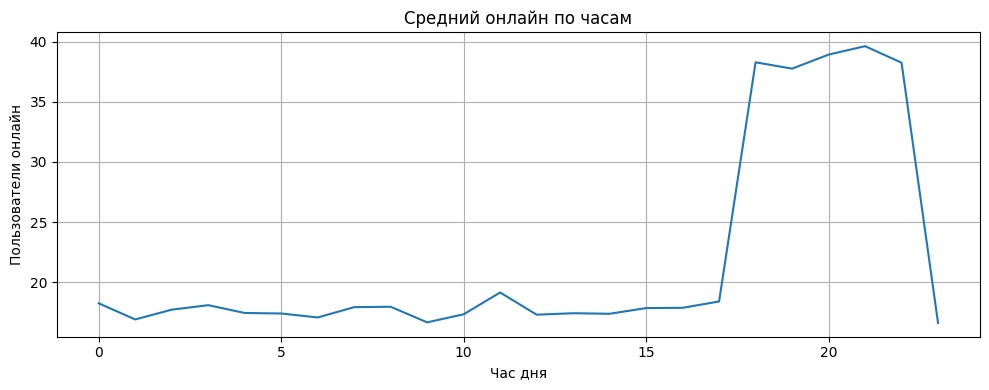

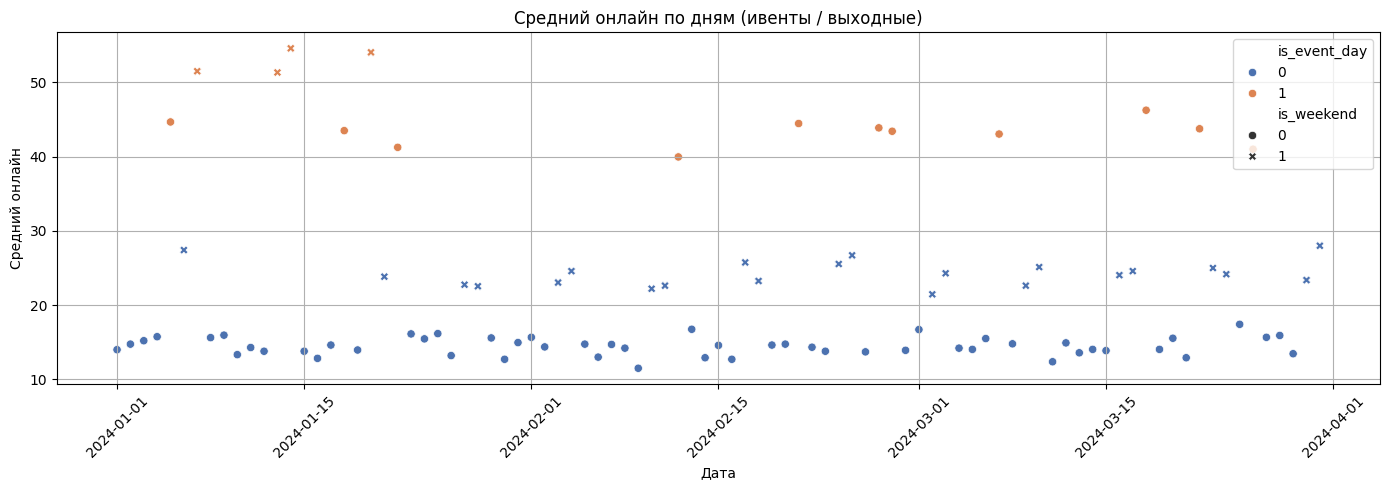

In [5]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x="hour", y="users_online", ci=None)
plt.title("Средний онлайн по часам")
plt.xlabel("Час дня")
plt.ylabel("Пользователи онлайн")
plt.grid(True)
plt.tight_layout()
plt.show()

df['date'] = df['datetime'].dt.date
daily_avg = df.groupby('date').agg({
    'users_online': 'mean',
    'is_weekend': 'max',
    'is_event_day': 'max'
}).reset_index()

plt.figure(figsize=(14, 5))
sns.scatterplot(
    data=daily_avg,
    x='date',
    y='users_online',
    hue='is_event_day',
    style='is_weekend',
    palette='deep'
)
plt.title("Средний онлайн по дням (ивенты / выходные)")
plt.xlabel("Дата")
plt.ylabel("Средний онлайн")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
features = [
    'hour', 'dayofweek', 'is_weekend', 'is_peak_hour', 'is_event_day',
    'prev_hour_users', 'prev_2_hour_users', 'prev_3_hour_users',
    'rolling_mean_3h', 'rolling_std_3h'
]
X = df[features]
y = df['users_online']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Модель градиентного бустинга
regressor = HistGradientBoostingRegressor(max_iter=200, random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# ===== Шаг 5: Метрики и визуализация =====
server_capacity = 20
servers_needed = [ceil(p / server_capacity) for p in y_pred]

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


Метрики модели (Boosting):
MAE  (средняя абсолютная ошибка):      1.38
RMSE (среднеквадратичная ошибка):      2.37
R²    (коэффициент детерминации):      0.98


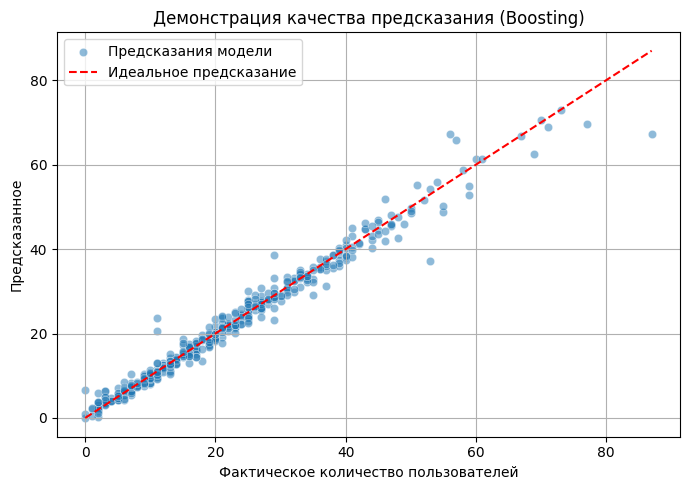

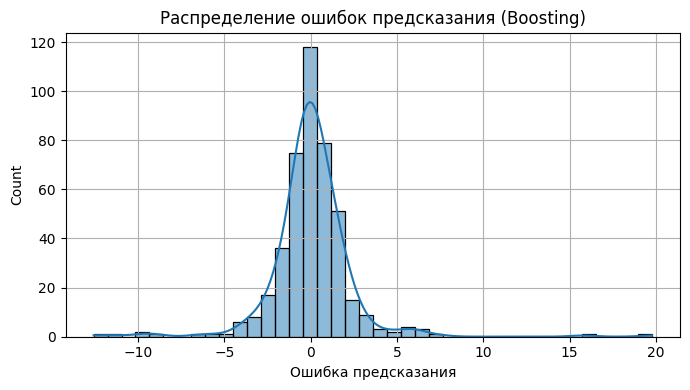

In [11]:
print(f"\nМетрики модели (Boosting):")
print(f"MAE  (средняя абсолютная ошибка):      {mae:.2f}")
print(f"RMSE (среднеквадратичная ошибка):      {rmse:.2f}")
print(f"R²    (коэффициент детерминации):      {r2:.2f}")

plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, label='Предсказания модели')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Идеальное предсказание')
plt.xlabel("Фактическое количество пользователей")
plt.ylabel("Предсказанное")
plt.title("Демонстрация качества предсказания (Boosting)")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- График: Ошибки предсказания ---
residuals = y_test - y_pred
plt.figure(figsize=(7, 4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Распределение ошибок предсказания (Boosting)")
plt.xlabel("Ошибка предсказания")
plt.grid(True)
plt.tight_layout()
plt.show()


Важность признаков (Permutation Importance):
             feature  importance
8    rolling_mean_3h   21.352157
6  prev_2_hour_users    5.821487
5    prev_hour_users    5.609676
9     rolling_std_3h    1.162648
3       is_peak_hour    0.715272
4       is_event_day    0.279937
0               hour    0.200271
1          dayofweek    0.091798
7  prev_3_hour_users    0.017510
2         is_weekend    0.000000


<ipython-input-8-0605d748ec7b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances_df, x='importance', y='feature', palette='viridis')


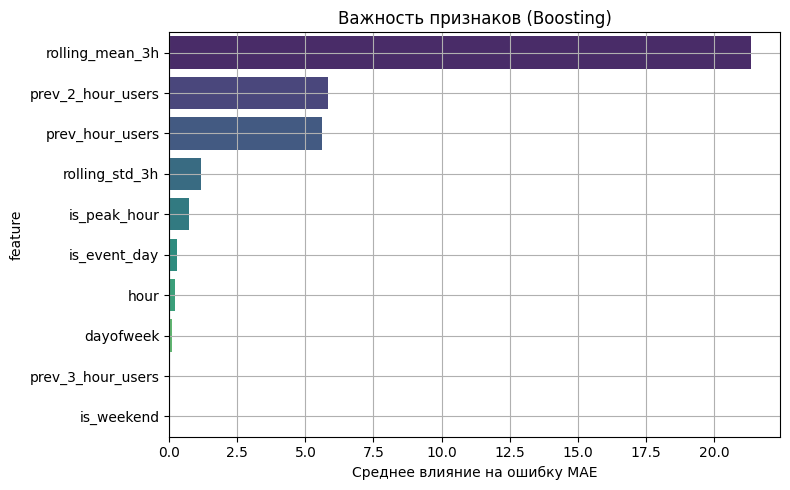

In [8]:
perm_result = permutation_importance(
    regressor, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error'
)

importances_df = pd.DataFrame({
    'feature': features,
    'importance': perm_result.importances_mean
}).sort_values(by='importance', ascending=False)

print("\nВажность признаков (Permutation Importance):")
print(importances_df)

# График важности
plt.figure(figsize=(8, 5))
sns.barplot(data=importances_df, x='importance', y='feature', palette='viridis')
plt.title("Важность признаков (Boosting)")
plt.xlabel("Среднее влияние на ошибку MAE")
plt.grid(True)
plt.tight_layout()
plt.show()